In [1]:
import os, pandas as pd, seaborn as sns
from matplotlib import pyplot as plt 
from sklearn.metrics import confusion_matrix
from dotenv import load_dotenv
print(os.getcwd())

load_dotenv('../.env_analysis')

DATA_DIR=os.environ["DATA_DIR"]
PROJECT_DIR=os.environ["PROJECT_DIR"]
PROJECT_INPUT_DATA_DIR=os.environ["PROJECT_INPUT_DATA_DIR"]
DNS=os.environ["DNS"]
IMAGES_DB=os.environ["IMAGES_DB"]
DB_PORT=os.environ["DB_PORT"]
DB_ADMIN_USER=os.environ["DB_ADMIN_USER"]
DB_ADMIN_PASS=os.environ["DB_ADMIN_PASS"]
ADMIN_PARTY=True if os.environ["ADMIN_PARTY"] == 'True' else False

print(f"""
DATA_DIR: {DATA_DIR}
PROJECT_DIR: {PROJECT_DIR}
PROJECT_INPUT_DATA_DIR: {PROJECT_INPUT_DATA_DIR}
DNS: {DNS}
IMAGES_DB: {IMAGES_DB}
DB_PORT: {DB_PORT}
DB_ADMIN_USER: {DB_ADMIN_USER}
DB_ADMIN_PASS: {DB_ADMIN_PASS}
ADMIN_PARTY: {ADMIN_PARTY}
""")



/home/bearceb/Image-Comparator-Anaylsis/analysis

DATA_DIR: 
PROJECT_DIR: /sddata/app_or_generated_data/Image-Comparator-Analysis/analysis/flicker_abstract_results_12_07_2023
PROJECT_INPUT_DATA_DIR: /sddata/app_or_generated_data/Image-Comparator-Analysis/raw_annotations/arvo_abstract_flicker_12_06_2023
DNS: qtimview.southcentralus.cloudapp.azure.com
IMAGES_DB: image_comparator
DB_PORT: 5984
DB_ADMIN_USER: admin
DB_ADMIN_PASS: los_gehts
ADMIN_PARTY: False



Read in everyone's annotations:

In [2]:
all_classify = pd.read_csv(os.path.join(PROJECT_INPUT_DATA_DIR, "all-v2_12_1_23-classify-0.csv"))
all_compare = pd.read_csv(os.path.join(PROJECT_INPUT_DATA_DIR, "all-v2_12_1_23-compare-0.csv"))
all_flicker = pd.read_csv(os.path.join(PROJECT_INPUT_DATA_DIR, "all-v2_12_1_23-flicker-0.csv"))

all_classify.rename(columns={"Image":"CDR"}, inplace=True)

## Stats to perform, maybe???

[*] Interater variability - raw CDR
  - Avg CDR by image even though there are 2 time points
  - Get each persons Estimated CDR by these images
  - plot is x-axis is average, and y-axis is estimated.
    * there might be images where avg was same value, this will allow for multiple estimated CDRs by person to show up on this average
  - Plot raters against each other
    * 


[] Rater v Scott's Model
  - 3 plots

[] Bar plots for each rater showing counts for categories of radio buttons
  - 3 plots


### Interater Variability

#### Expected v Average

In [3]:
mcnamast_classify = all_classify[all_classify['user'] == 'mcnamast']
gdeitz_classify = all_classify[all_classify['user'] == 'gdeitz']
swangyu_classify = all_classify[all_classify['user'] == 'swangyu']

In [4]:
average_classify = all_classify.groupby('image_id').mean("CDR")
average_classify.reset_index(inplace=True)

In [5]:
print(f"""
shapes: mcnamast: {mcnamast_classify.shape} 
gdeitz: {gdeitz_classify.shape} 
swangyu: {swangyu_classify.shape}
average: {average_classify.shape}
""")


shapes: mcnamast: (40, 6) 
gdeitz: (40, 6) 
swangyu: (40, 6)
average: (40, 2)



In [6]:
average_classify.head()

,image_id,CDR
0,flicker_fixed_mild_prog_114_axis01_4599_135545...,0.733333
1,flicker_fixed_mild_prog_165_AxisUCH01_1408_651...,0.816667
2,flicker_fixed_mild_prog_167_axis01_5625_157069...,0.500000
3,flicker_fixed_mild_prog_30_AxisUCH01_3790_6086...,0.433333
4,flicker_fixed_mild_prog_33_axis01_4536_144180_...,0.350000


In [7]:
mcnamast_classify.sort_values('image_id', inplace=True);
gdeitz_classify.sort_values('image_id', inplace=True);
swangyu_classify.sort_values('image_id', inplace=True);
average_classify.sort_values('image_id', inplace=True);

/tmp/ipykernel_1024674/3316517193.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mcnamast_classify.sort_values('image_id', inplace=True);
/tmp/ipykernel_1024674/3316517193.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdeitz_classify.sort_values('image_id', inplace=True);
/tmp/ipykernel_1024674/3316517193.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swangyu_classify.sort_values('image_id', inplace=True);


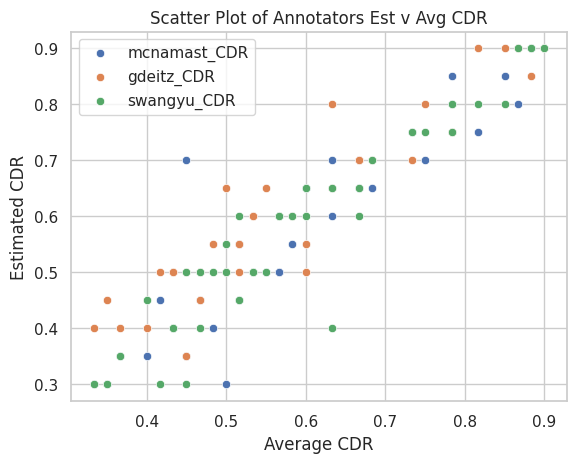

In [139]:
data_classify = pd.DataFrame({
"image_id": list(average_classify['image_id']),
"average_CDR": list(average_classify['CDR']),
"mcnamast_CDR": list(mcnamast_classify['CDR']),
"gdeitz_CDR": list(gdeitz_classify['CDR']),
"swangyu_CDR": list(swangyu_classify['CDR']),
})

sns.scatterplot(data=data_classify, x='average_CDR', y='mcnamast_CDR', label='mcnamast_CDR')
sns.scatterplot(data=data_classify, x='average_CDR', y='gdeitz_CDR', label='gdeitz_CDR')
sns.scatterplot(data=data_classify, x='average_CDR', y='swangyu_CDR', label='swangyu_CDR')


# Melt the DataFrame to create a single column for y-values and another for category labels
# melted_data = data.melt(id_vars=['image_id'], var_name='annotator', value_name='CDR')
# melted_data
# Create a scatter plot with different colors for each category
# sns.scatterplot(data=melted_data, x='average_CDR', y='CDR', hue='annotator')

# # # Customize the plot
plt.xlabel('Average CDR')
plt.ylabel('Estimated CDR')
plt.title('Scatter Plot of Annotators Est v Avg CDR')
plt.legend()

# Show the plot
plt.show()


#### Raters Against Each Other

In [51]:
mcnamast_compare = all_compare[all_compare['user'] == 'mcnamast']
gdeitz_compare = all_compare[all_compare['user'] == 'gdeitz']
swangyu_compare = all_compare[all_compare['user'] == 'swangyu']

mcnamast_compare.sort_values(['image_1_id', 'image_2_id'], inplace=True)
gdeitz_compare.sort_values(['image_1_id', 'image_2_id'], inplace=True)
swangyu_compare.sort_values(['image_1_id', 'image_2_id'], inplace=True)
all_compare.sort_values(['image_1_id', 'image_2_id'], inplace=True)

mcnamast_flicker = all_flicker[all_flicker['user'] == 'mcnamast']
gdeitz_flicker = all_flicker[all_flicker['user'] == 'gdeitz']
swangyu_flicker = all_flicker[all_flicker['user'] == 'swangyu']
all_flicker.sort_values(['image_1_id', 'image_2_id'], inplace=True)

mcnamast_flicker.sort_values(['image_1_id', 'image_2_id'], inplace=True)
gdeitz_flicker.sort_values(['image_1_id', 'image_2_id'], inplace=True)
swangyu_flicker.sort_values(['image_1_id', 'image_2_id'], inplace=True)



/tmp/ipykernel_1024674/2749705758.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mcnamast_compare.sort_values(['image_1_id', 'image_2_id'], inplace=True)
/tmp/ipykernel_1024674/2749705758.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdeitz_compare.sort_values(['image_1_id', 'image_2_id'], inplace=True)
/tmp/ipykernel_1024674/2749705758.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  swangyu_compare.sort_values(['image_1

In [14]:
mcnamast_compare['Choose CDR Desc']
gdeitz_compare['Choose CDR Desc']
swangyu_compare['Choose CDR Desc']

mcnamast_flicker['Choose CDR Desc']
gdeitz_flicker['Choose CDR Desc']
swangyu_flicker['Choose CDR Desc']

40                            Stable (CDR change 0.0)
41          Mild Progression (CDR change 0.00 - 0.15)
42    Significant Progression (CDR change 0.15 - 0.3)
43                            Stable (CDR change 0.0)
44                            Stable (CDR change 0.0)
45    Significant Progression (CDR change 0.15 - 0.3)
46          Mild Progression (CDR change 0.00 - 0.15)
47    Significant Progression (CDR change 0.15 - 0.3)
48                            Stable (CDR change 0.0)
49                            Stable (CDR change 0.0)
50          Mild Progression (CDR change 0.00 - 0.15)
51                            Stable (CDR change 0.0)
52          Mild Progression (CDR change 0.00 - 0.15)
53                            Stable (CDR change 0.0)
54                            Stable (CDR change 0.0)
55          Mild Progression (CDR change 0.00 - 0.15)
56                            Stable (CDR change 0.0)
57                            Stable (CDR change 0.0)
58                          

In [18]:
# mcnamast_compare[['image_1_id', 'image_2_id', 'Choose CDR Desc']]

In [19]:
# gdeitz_compare[['image_1_id', 'image_2_id', 'Choose CDR Desc']]

In [25]:
def make_confusing(ann1, ann2):
    # Create a confusion matrix
    cm = confusion_matrix(ann1['data']['Choose CDR Desc'], ann2['data']['Choose CDR Desc'], labels=['Stable (CDR change 0.0)', 'Mild Progression (CDR change 0.00 - 0.15)', 'Significant Progression (CDR change 0.15 - 0.3)'])
    # Plot the confusion matrix as a heatmap
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Stable (CDR change 0.0)', 'Mild Progression (CDR change 0.00 - 0.15)', 'Significant Progression (CDR change 0.15 - 0.3)'],
                yticklabels=['Stable (CDR change 0.0)', 'Mild Progression (CDR change 0.00 - 0.15)', 'Significant Progression (CDR change 0.15 - 0.3)'])
    plt.xlabel(f"{ann2['ann']} Labels")
    plt.ylabel(f"{ann1['ann']} Labels")
    plt.title('Confusion Matrix')
    plt.show()


In [26]:
ann1 = {"ann": "mcnamara", "data": mcnamast_compare[['image_1_id', 'image_2_id', 'Choose CDR Desc']]}
ann2 = {"ann": "gdeitz", "data": gdeitz_compare[['image_1_id', 'image_2_id', 'Choose CDR Desc']]}
ann3 = {"ann": "swangyu", "data": swangyu_compare[['image_1_id', 'image_2_id', 'Choose CDR Desc']]}

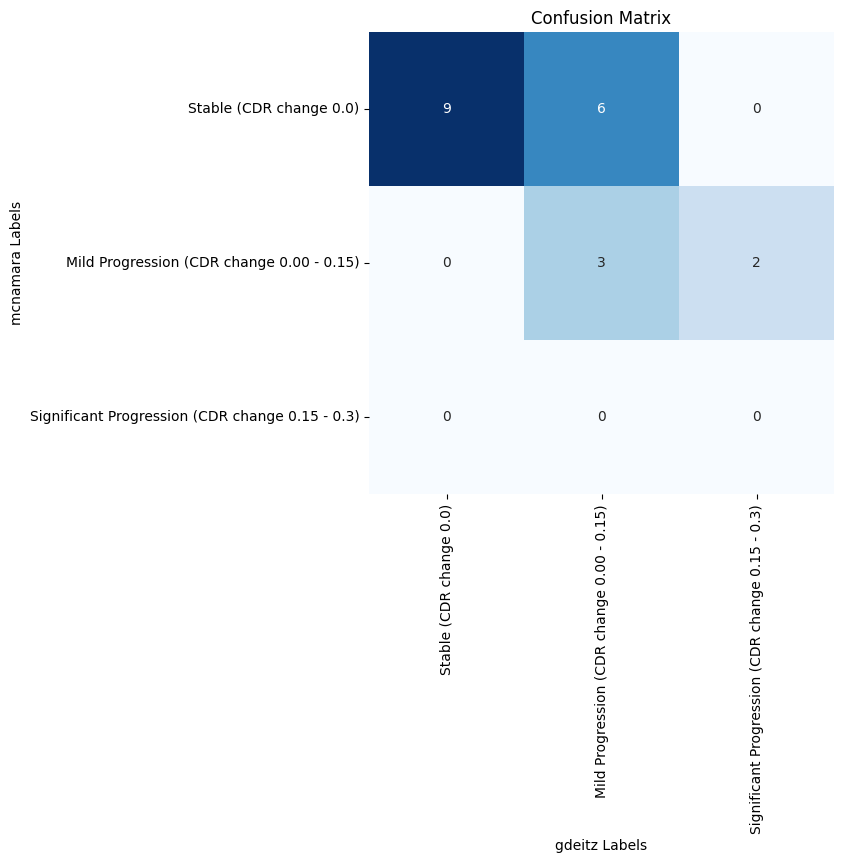

In [29]:
make_confusing(ann1, ann2)

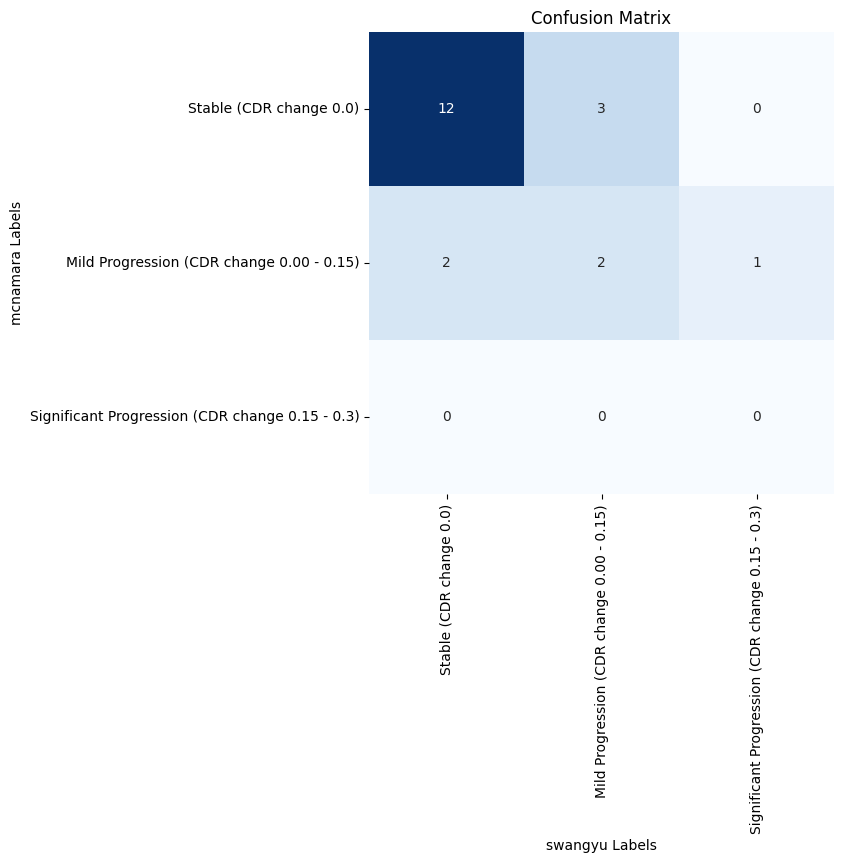

In [30]:
make_confusing(ann1, ann3)

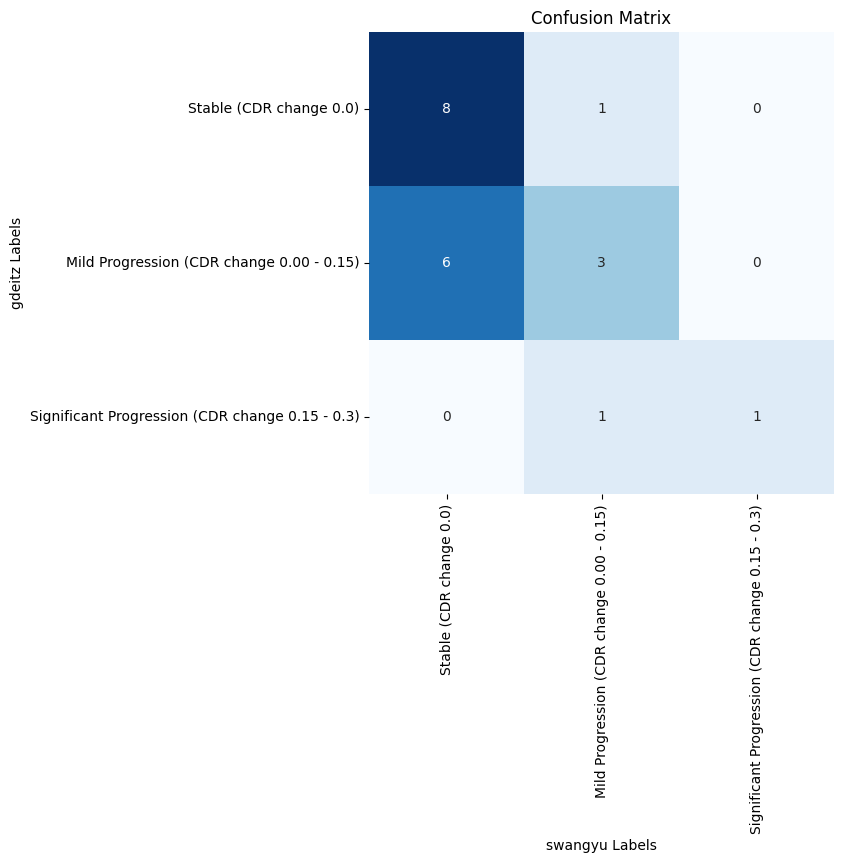

In [31]:
make_confusing(ann2, ann3)

In [38]:
ann1 = {"ann": "mcnamara", "data": mcnamast_flicker[['image_1_id', 'image_2_id', 'Choose CDR Desc']]}
ann2 = {"ann": "gdeitz", "data": gdeitz_flicker[['image_1_id', 'image_2_id', 'Choose CDR Desc']]}
ann3 = {"ann": "swangyu", "data": swangyu_flicker[['image_1_id', 'image_2_id', 'Choose CDR Desc']]}

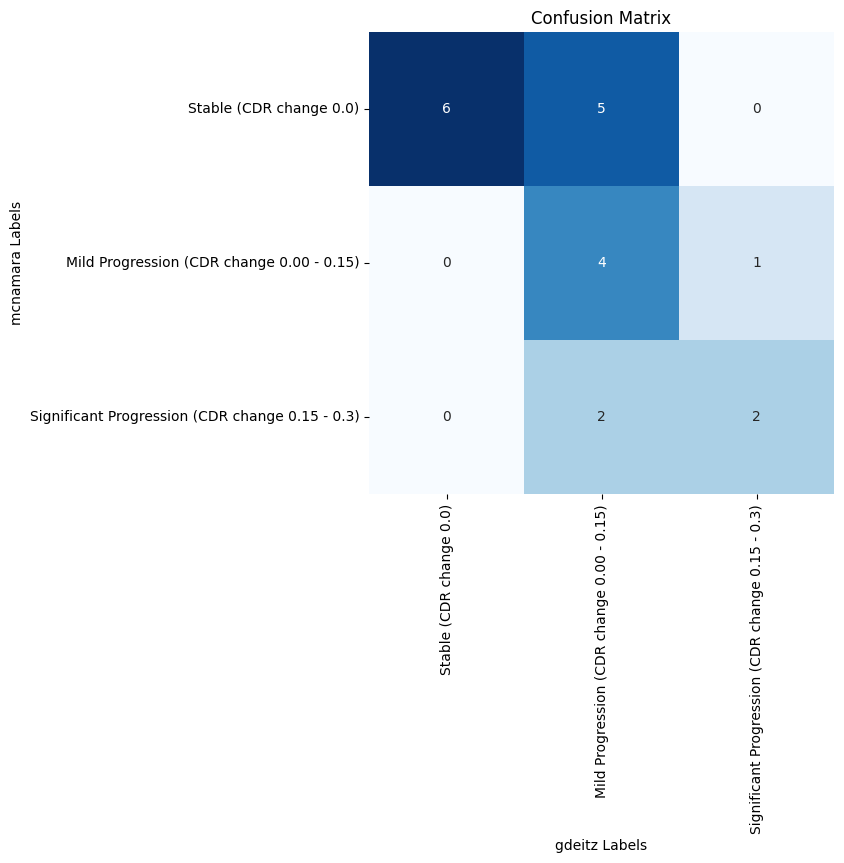

In [41]:
make_confusing(ann1, ann2)

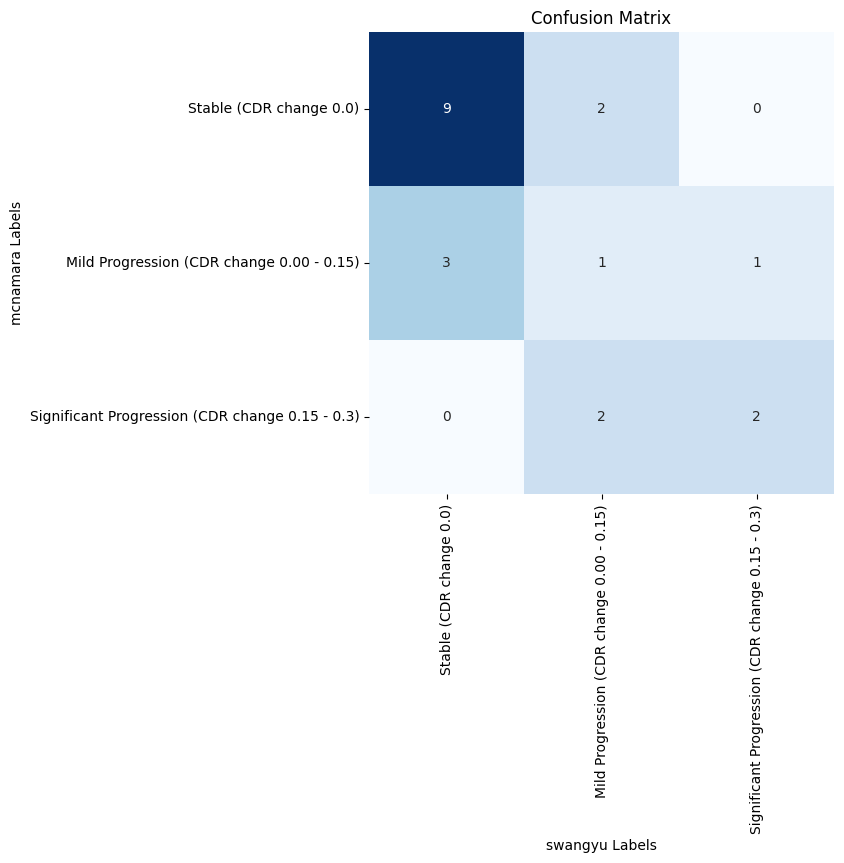

In [42]:
make_confusing(ann1, ann3)

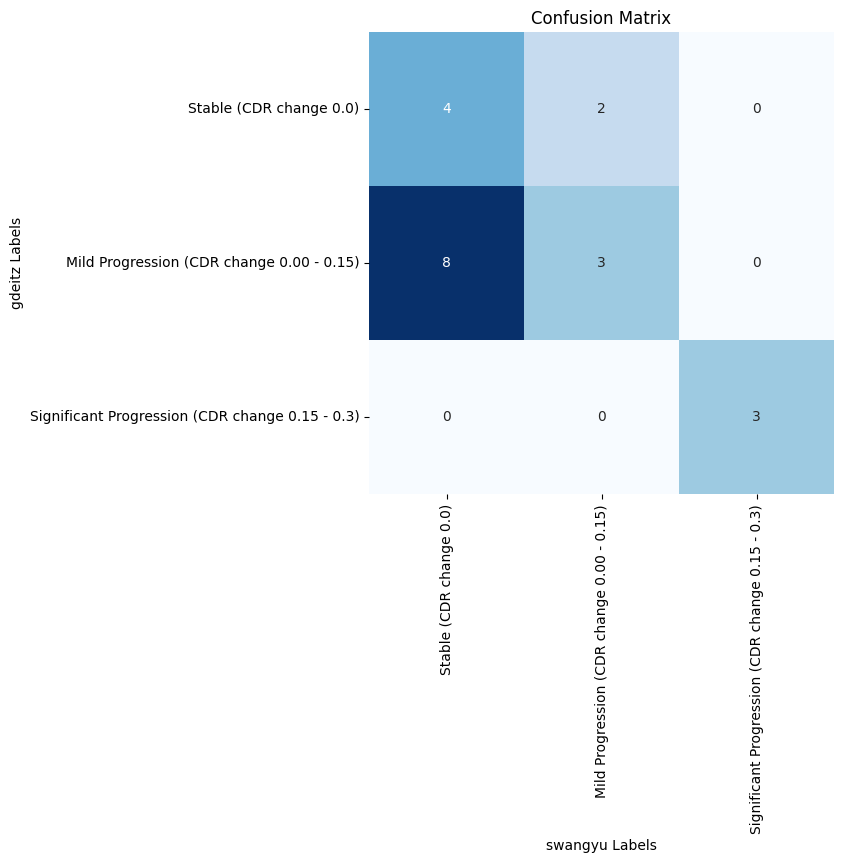

In [43]:
make_confusing(ann2, ann3)

### Boxes

In [45]:

def plot_annotator_bar_plot(compare, flicker, annotator=""):
    data = pd.DataFrame({
        "Choose CDR Desc": list(compare['Choose CDR Desc']) + list(flicker['Choose CDR Desc']),
        "app": ["compare"]*len(compare[['taskid','Choose CDR Desc']]) + ["flicker"]*len(flicker[['taskid','Choose CDR Desc']])
    })

    # Create a countplot
    sns.set(style="whitegrid")
    ax = sns.countplot(data=data, x='Choose CDR Desc', hue='app')


    # Customize the plot
    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.title(f"Annotator {annotator} Bar Chart with 3 Categories, Compare v Flicker")
    plt.legend(title='Source')

    # Rotate x-axis labels
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)  # Adjust the rotation angle as needed

    # Show the plot
    plt.show()


/tmp/ipykernel_1024674/3151096928.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)  # Adjust the rotation angle as needed


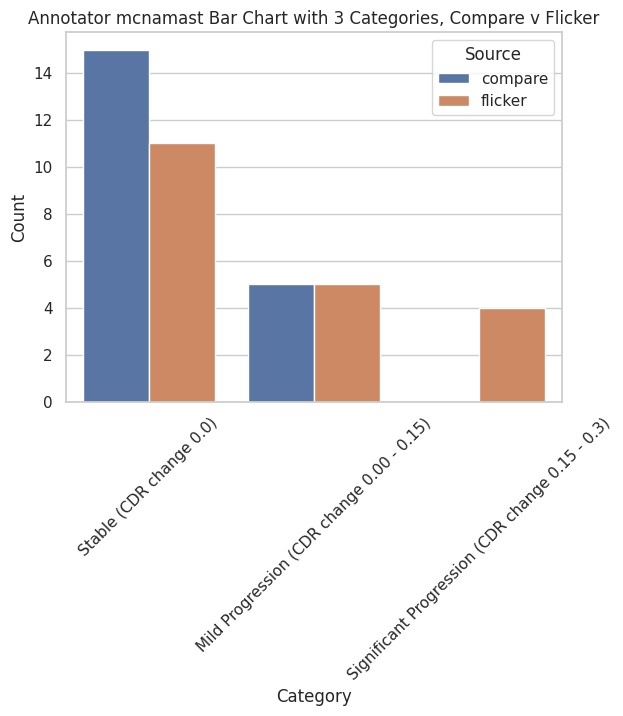

In [46]:
plot_annotator_bar_plot(mcnamast_compare, mcnamast_flicker, annotator="mcnamast")

/tmp/ipykernel_1024674/3151096928.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)  # Adjust the rotation angle as needed


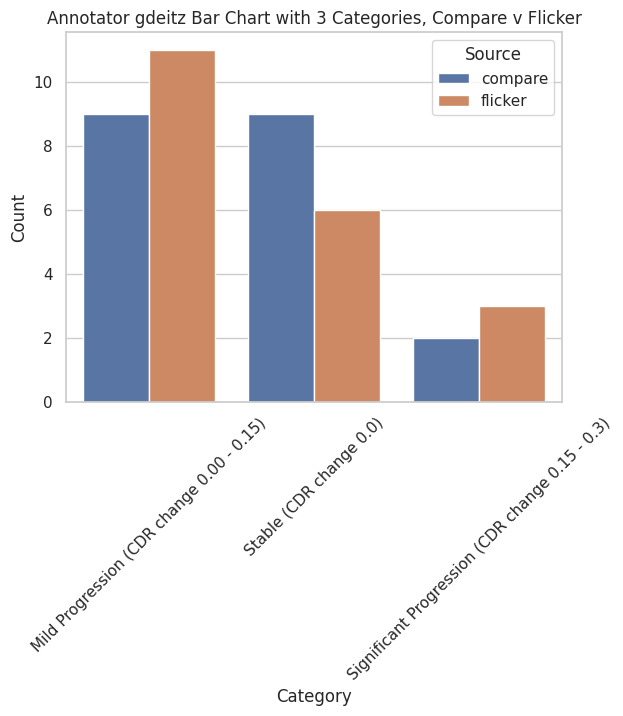

In [49]:
plot_annotator_bar_plot(gdeitz_compare, gdeitz_flicker, annotator="gdeitz")

/tmp/ipykernel_1024674/3151096928.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)  # Adjust the rotation angle as needed


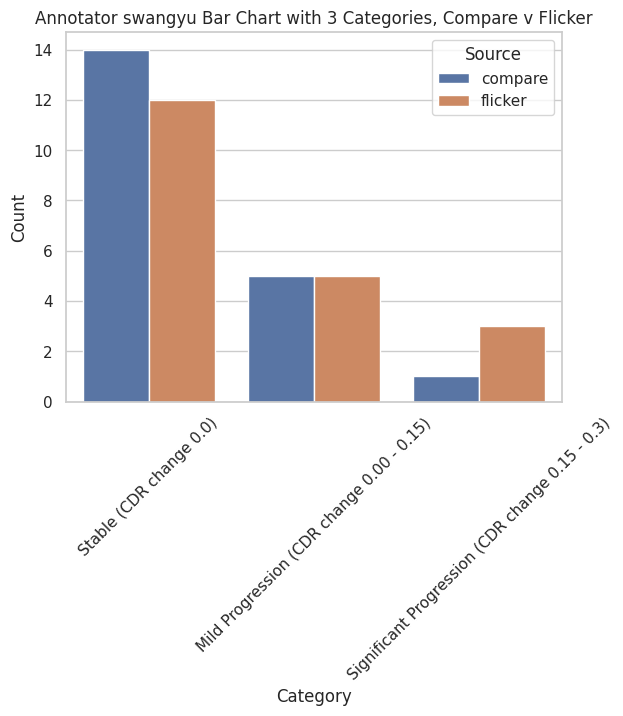

In [50]:
plot_annotator_bar_plot(swangyu_compare, swangyu_flicker, annotator="swangyu")

/tmp/ipykernel_1024674/3151096928.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)  # Adjust the rotation angle as needed


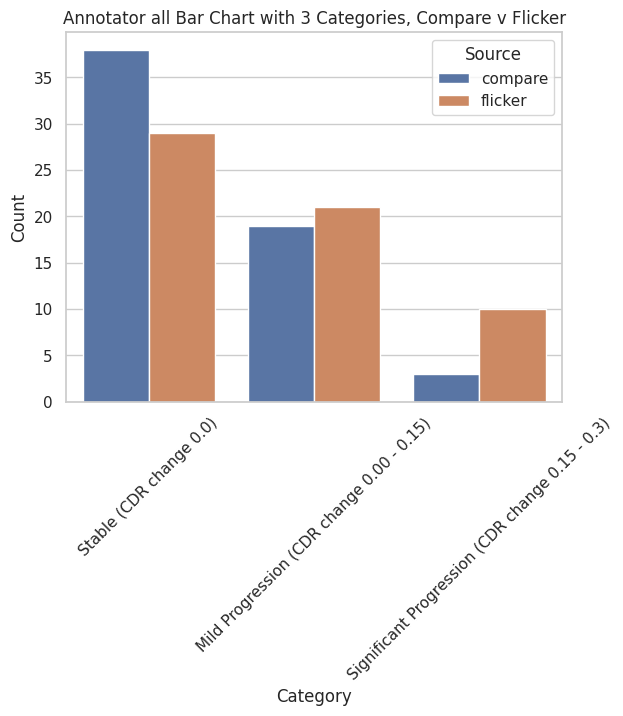

In [52]:
plot_annotator_bar_plot(all_compare, all_flicker, annotator="all")